# MCT4052 Workshop 8b: Tensorflow-Keras ANN Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train, test and use an ANN for regression in tensorflow. We use the same dataset used in earlier Workshops.

### 1. Importing Tensorflow and Keras


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os
import sklearn
import scipy
import datetime

%matplotlib inline
%config IPCompleter.greedy=True

# Import TensorFlow and Keras
import tensorflow as tf

# display tensorflow version (this notwbook was developed with 2.7)
print(tf.__version__)

2.10.0


### 2. Computing features, targets and splitting the dataset

This time we store the features in an numpy array of matrices (i.e. a 3D array) ad tensorflow is able to "flatten" the data internally (is instructed to do so).

In [3]:
sr = 44100

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    features = librosa.feature.melspectrogram(y=signal, n_mels=32)
    
    features = lin_interp_2d(features, (32,16)) # scaling to identical lenght
    
    targets = np.zeros((1,2))
    #centroid and flatness are in very sifferent ranges, they are scaled to be in a similar range (important for the loss)
    targets[0,0] = np.mean(librosa.feature.spectral_centroid(y=signal))/1000 #scaling the centroid to smaller range
    targets[0,1] = np.mean(librosa.feature.spectral_flatness(y=signal))*100 #scaling the flatness to larger range
    
    return features, targets

filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),32,16)) #3D Numpy array to store MFCC computed e changed if using more or less features)
targets = np.zeros((len(filenames),2))

for i in range(len(filenames)):
    features[i,:,:], targets[i,:] = extract_features_targets('./data/examples2/'+filenames[i], sr) # alternative features[i,:,:]


print('Done!')

Done!


In [4]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.2)

### 3. Defining, compiling, training and using the ANN

Compared to the previous notebook, setting an appropriate loss function (related to the error) is a key element to train a regression model

In [6]:
# building the model, the input layer must match the input data
# for regression we need an output for each target value
# here we also integrate a normalization layer (not an absolute must)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 16)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(2, activation='relu')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 normalization_1 (Normalizat  (None, 512)              1025      
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6,177
Trainable params: 5,152
Non-trainable params: 1,025
_________________________________________________________________


In [7]:
# setting loss function and metric
# we also specify the learning rate, which needs to be further
# adjusted to speed up the training

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [8]:
# fitting the model and setting some parameters

history = model.fit(
    feat_train,
    tar_train,
    batch_size=32,
    epochs=500,
    validation_split = 0.1
)

Epoch 1/500


2023-03-21 21:46:06.561791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-21 21:46:06.721233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 91ms/step - loss: 10.2061 - val_loss: 11.2032
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 9.8886 - val_loss: 10.8960
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 9.7700 - val_loss: 10.6506
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 9.6394 - val_loss: 10.4679
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: 9.5370 - val_loss: 10.4419
Epoch 6/500
1/4 [======>.......................] - ETA: 0s - loss: 9.5458

2023-03-21 21:46:08.656771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step - loss: 9.4290 - val_loss: 10.4654
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 9.3283 - val_loss: 10.4883
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 9.2768 - val_loss: 10.4370
Epoch 9/500
4/4 [==============================] - 0s 11ms/step - loss: 9.2027 - val_loss: 10.3193
Epoch 10/500
4/4 [==============================] - 0s 11ms/step - loss: 9.1041 - val_loss: 10.2649
Epoch 11/500
4/4 [==============================] - 0s 11ms/step - loss: 9.1134 - val_loss: 10.1702
Epoch 12/500
4/4 [==============================] - 0s 10ms/step - loss: 9.0310 - val_loss: 10.1142
Epoch 13/500
4/4 [==============================] - 0s 11ms/step - loss: 8.9621 - val_loss: 10.0691
Epoch 14/500
4/4 [==============================] - 0s 10ms/step - loss: 8.9079 - val_loss: 9.9568
Epoch 15/500
4/4 [==============================] - 0s 10ms/step - loss: 8.8590 - val_loss: 9.9066
Epoch 16/500
4/4 [

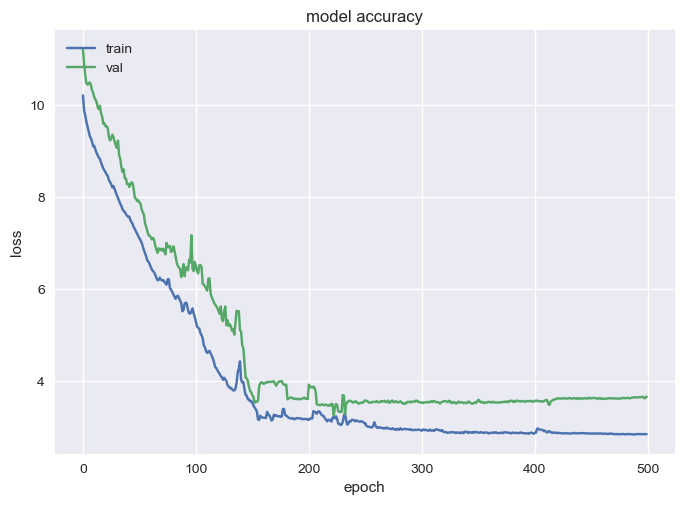

In [9]:
# plotting validation and train loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# evaluating performance on test set
# tensorflow provides many error-related metrics
# but it does not provide the R2 score (but we can still use scikit learn)

tar_pred = model.predict(feat_test)

print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_pred))

2/2 [==============================] - 0s 85ms/step
Coefficient of determination (r2 score): 0.5929


2023-03-21 21:46:33.834592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### 4. Follow up activities

1. Try to improve performances.